## Decision Trees: Predicting Survival with the Titanic Dataset

Bronwyn Bowles-King

### 1. Introduction

This Jupyter notebook explores the use of decision tree models, a type of decision learning, to predict the survival of the sinking of the Titanic, a well-known maritime disaster that occurred in 1912. We have a dataset of passenger information for use in machine learning and data analysis. The dataset contains information on demographic and ticket details, which are used to understand factors influencing survival.

Key variables relevant to predicting survival that will be considered here are:

**Sex**: Gender plays a crucial role in survival rates, with historical accounts indicating that women had a higher chance of survival. In this dataset, the 'Sex' column is *not* transformed using one-hot encoding (creating separate columns for males and females), as suggested in the task instructions. This is because it is not necessary as the data is already binary in nature and it makes the diagram more difficult to interpret. Instead, this column is changed to binary values (female = 0 and male = 1). 

**Pclass**: This refers to the numbered passenger class (first, second or third), which serves as a proxy for socio-economic status. Passengers in higher classes generally had better access to lifeboats and thus higher survival rates.

**Fare**: The fare paid for the ticket also reflects economic status and potentially cabin location. Fare is a continuous variable with wide variation, which can influence survival chances. To manage complexity, fare values are binned into four categories before modelling.

It is known that age also had an effect on survival rate, as children were placed on boats first alongside the women. However, almost 20% of this data is not available in this dataset and so age will not be included in the decision tree. 

By focusing on these features, the notebook demonstrates how decision trees can capture patterns in the data to classify passengers as survivors or non-survivors. The notebook includes data preparation, model training with varying tree depths, visualisation of decision trees, and evaluation of model accuracy, providing a comprehensive overview of the modelling process.

### 2. Preparation steps

##### 2.1 Import libraries and load dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

titanic_df = pd.read_csv("titanic.csv")

#### 2.2 Check for missing values and duplicates and remove unnecessary columns

The number of missing values and duplicates are checked and then the columns that are not needed for the analysis are dropped. 

In [2]:
print("Missing values:")
print(titanic_df.isnull().sum())  

Missing values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [3]:
print(f'Duplicate rows: {titanic_df.duplicated().sum()}')

Duplicate rows: 0


In [4]:
titanic_df = titanic_df.drop(['Cabin', 'Age', 'Embarked', 'Name', 'Ticket', 'SibSp', 'Parch'], axis=1)

### 3. Convert gender to binary values and create fare bins for machine learning and analysis

The column 'Sex' is changed to integers (female = 0, male = 1) and fare categories or bins are created for use in the decision tree classifier. The ranges of the fare bins are printed at the end. 

In [5]:
# Only run this line of code once to avoid casting error
titanic_df['Sex'] = titanic_df['Sex'].map({'female': 0, 'male': 1}).astype(int)  

In [6]:
titanic_df['Fare_bin'] = pd.cut(titanic_df['Fare'], bins=4, labels=[0, 1, 2, 3])
fare_bins = pd.cut(titanic_df['Fare'], bins=4)
for i, interval in enumerate(fare_bins.cat.categories):
    print(f'Bin {i}: {interval.left:.2f} to {interval.right:.2f}')

Bin 0: -0.51 to 128.08
Bin 1: 128.08 to 256.17
Bin 2: 256.17 to 384.25
Bin 3: 384.25 to 512.33


### 4. Create decision tree model 

#### 4.1 Determine features and target for prediction

The features for prediction are gender ('Sex'), passenger class ('Pclass'), the range of fare paid ('Fare_bin'). Together, these are called 'features' and are the X variable. The target (y) that will be predicted upon is the 'Survived' column and thus whether a particular passenger survived based on their gender, class and fare paid. These are assigned to variables below.

In [7]:
features_X = titanic_df[['Pclass', 'Sex', 'Fare_bin']]
target_y = titanic_df['Survived']

#### 4.2 Split the data into training, development and test sets

The data is split into a temporary set of 80% (which is to be redivided in the next step), and a test set of 20%. The temporary set is then further split into a training set of 80% and development set of 20% and the final size of the sets is printed to show the number of samples that the model will be working with in each case. The model is then fit on the larger training set in the next section. The development set is used later to help refine the model.

In [8]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    features_X, target_y, test_size=0.2, random_state=42, stratify=target_y
) 

X_train, X_dev, y_train, y_dev = train_test_split(
    X_train_temp, y_train_temp, test_size=0.2, random_state=42, stratify=y_train_temp
)

print(f"Training set size: {len(X_train)} samples")  
print(f"Development set size: {len(X_dev)} samples")  
print(f"Test set size: {len(X_test)} samples") 

Training set size: 569 samples
Development set size: 143 samples
Test set size: 179 samples


#### 4.3 Fit classifier on training data

The classifier (clf) is instantiated below with no depth limit on the size of the tree and the classifier is then fit on the training data. To see the classifier's results, the decision tree is created in the next section. A random_state is set so that the results are consistent when rnuning the code more than once.

In [9]:
clf = DecisionTreeClassifier(random_state=42)  # max_depth=None by default

clf.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


#### 4.4 Plot decision tree diagram

A decision tree is similar to a flowchart and it helps us see how the model makes predictions about the target variable based on the features supplied. The decision tree below (Figure 1) shows the patterns of survival on the Titanic. The tree works by asking a series of questions or splitting rules about the features to divide the passengers into groups with increasingly similar survival outcomes.

Orange nodes (blocks) in Figure 1 show that the majority in the group did not survive (class = Not survived). The blue nodes show that the majority in the group survived (class = Survived). In most cases, the blocks are orange and 'Not survived' is predicted. This makes sense as most Titanic passangers died by drowning or hypothermia. 

Where the nodes are darker in colour, there is higher 'purity', meaning almost everyone in that group has the outcome shown (class = Not survived or Survived), and a lighter colour means the minority fit into the group. 

It is important to note that every split to the left is True for the splitting rule and False for splits to the right. The Boolean logic shown at the top of the figure thus continues throughout the diagram.

It is not possible to explain the whole figure as it is somewhat complex, but the following examples of the logic applied in the first eight nodes and leaves will be discussed:

**Root node**

* Node #0: First splitting rule based on gender (Sex < 0.5 is 0 for females), with females thereafter going off to the left (True) and males to the right (False).  
  
**Decision nodes**

* Node #1: Splitting rule for females based on passenger class (Pclass <= 2.5 is 1 and 2, i.e. first and second class). 
* Node #2: Females in first class only (Pclass <= 1.5 is 1).
* Node #3: Next splitting rule for females in first class, with those paying the lowest fare (Fare_bin <= 0.5 is 0) thereafter going off to the left (True) and those paying a higher fare than this going to the right (False). 

**Terminal nodes**

* Leaf #4: Females in first class and fare bin 0. Final group no longer split.
* Leaf #5: Females in first class with fares in bin 1, 2 or 3. 
* Leaf #6: Females in second class. Split off from node #2.
* Leaf #7: Females in third class. Split off from node #1.

The figure created by the sklearn package is fairly complex and lacks sufficent information to make it easily and readily interpretable. This is a result of the number of variables and splits. It is thus preferable to keep a tree smaller with fewer branches. Different tree sizes will be tested for this data in section 5. 

Although decision trees can be complex, the method has the advantages of handling mixed data types (both numbers and categories), there is no need for data scaling in many cases, they can work with raw data directly, they capture complex decision boundaries, and are the foundation for other approaches (Saini, 2025).

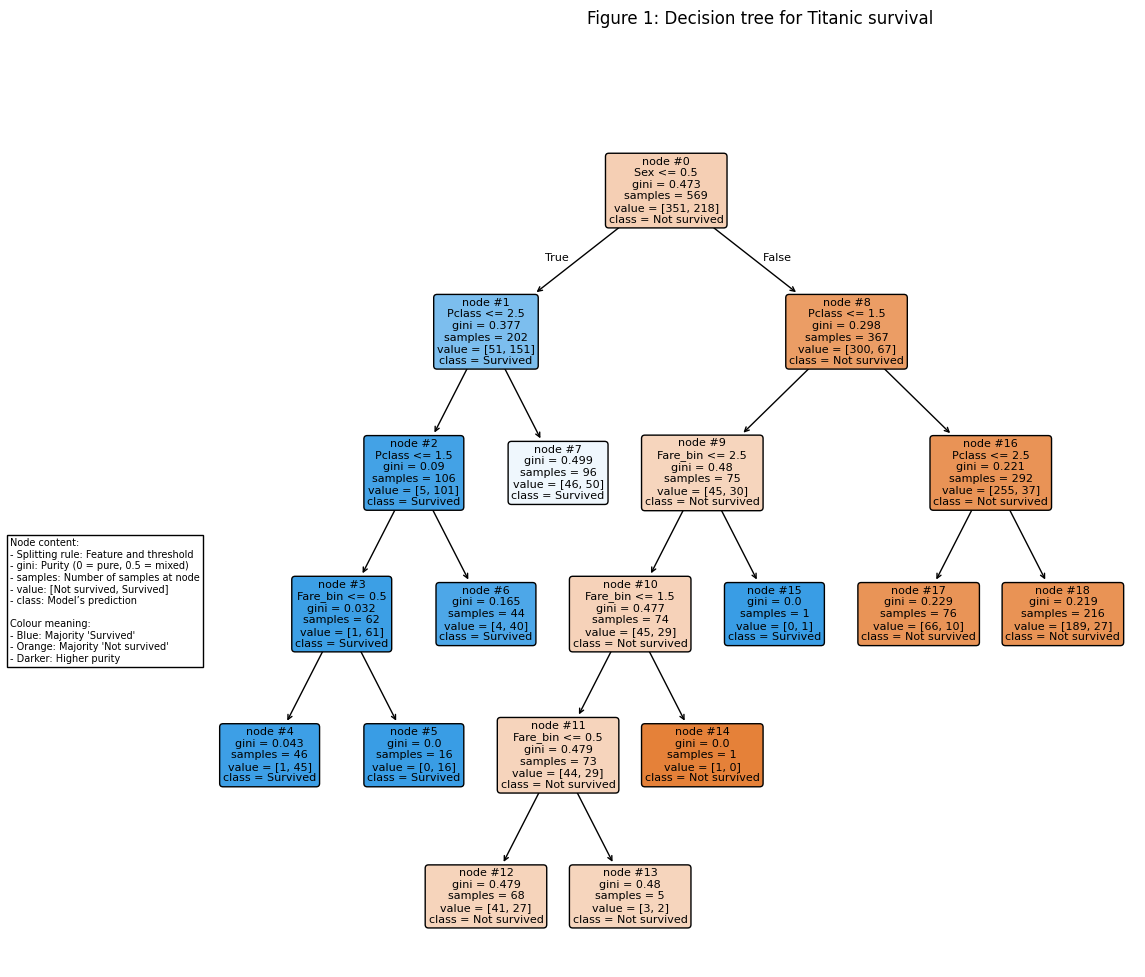

In [10]:
plt.figure(figsize=(15, 11))
plot_tree(
    clf,
    feature_names=['Pclass', 'Sex', 'Fare_bin'],
    class_names=['Not survived', 'Survived'],
    filled=True,
    rounded=True,
    label='all',
    node_ids=True,
    fontsize=8
)
plt.suptitle("Figure 1: Decision tree for Titanic survival")
plt.gcf().text(
    0, 0.5,
    (
        "Node content:\n"
        "- Splitting rule: Feature and threshold\n"
        "- gini: Purity (0 = pure, 0.5 = mixed)\n"
        "- samples: Number of samples at node\n"
        "- value: [Not survived, Survived]\n"
        "- class: Model’s prediction\n\n"
        "Colour meaning:\n"
        "- Blue: Majority 'Survived'\n"
        "- Orange: Majority 'Not survived'\n"
        "- Darker: Higher purity"
    ),
    fontsize=7, va='top', bbox=dict(boxstyle="square", fc="w", ec="k")
)

plt.subplots_adjust(right=0.75)
plt.show()


#### 4.5 Analysis of decision tree diagram and model performance on training data

The root node (node #0) at the top of the tree in Figure 1 starts with the most important feature for splitting the data, as determined by the training model, sklearn's DecisionTreeClassifier. Gender is the most important feature in determining survival because women (and children) were placed onto the Titanic's rescue boats first.

Node #0 shows there are 569 samples in the group (training dataset) at this point; 351 are predicted to die (about 62%) and 218 are predicted to survive (about 38%). This is in line with the actual survival rate of the passengers in the whole dataset: 342 survived out of 891 total people in the dataset, which is also 38%, as shown below.

In [11]:
survived = titanic_df[
    (titanic_df['Survived'] == 1)
].shape[0]
print(f"Survivors: {survived}")

all_passengers = titanic_df.shape[0]
print(f"Total passengers: {all_passengers}")

print(f"Survival of Titanic passengers in dataset: {(survived / all_passengers) * 100:.2f}%")

Survivors: 342
Total passengers: 891
Survival of Titanic passengers in dataset: 38.38%


The tree splits to the left into node #1 (blue) for females with 202 samples, and node #8 (orange) for males with 367 samples. The left blue branch (node #1) is for females since the splitting rule stated in the node (Sex < 0.5) is only True for females (female = 0 and male = 1 in the dataset). 

Node #1 shows a splitting rule Pclass <= 2.5 (equal to or less than 2.5), which means 1 and 2 in this context, and thus first and second class. At this stage, the model is checking if the feature of being in a higher passenger class, and so of a higher socioeconomic level in general, makes a difference to the survival rate for women.

Node #2 shows the splitting rule for women in first class (Pclass <= 1.5 is 1), and it is at node #3 that this group is split into leaf #4 for those paying the lowest fare and leaf #5 for those paying higher fares. The algorithm then stops splitting the passengers as it does not find anything further statistically significant. 

In other words, there is no meaningful improvement in prediction accuracy or information gain when splitting the data further. This is based on the metric Gini impurity, which is shown in each node, or it can be based on the rules specified when creating the decision tree. No rules were specified in the code and so this is based on the Gini value (IBM, n.d.). 

Leaf #4 concerns 46 females in first class and paying the lowest or no fare (under about £128). It is unlikely that no fare was paid for all these upper-class women at all, but that we do not have a record of it as their fare was included with those of their family members. Of these 46, women, only 1 is predicted as not surviving. This high survival rate here of 98% is in line with the actual data, which shows that 98.5% survived (see next code block output). It is also known that more women in higher passenger classes survived as they were shown some preference (Steiger, 2017).

In [12]:
fe_class1_bin0 = titanic_df[
    (titanic_df['Sex'] == 0) & 
    (titanic_df['Pclass'] == 1) &
    (titanic_df['Fare_bin'] == 0) 
].shape[0]
print(f"Total women in Pclass 1 and Fare bin 0: {fe_class1_bin0}")

fe_class1_bin0_survived = titanic_df[
    (titanic_df['Sex'] == 0) & 
    (titanic_df['Pclass'] == 1) &
    (titanic_df['Fare_bin'] == 0) &
    (titanic_df['Survived'] == 1)
].shape[0]
print(f"Women in Pclass 1 and Fare bin 0 who survived: {fe_class1_bin0_survived}")

print(f"Survival of women in Pclass 1 and Fare bin 0: {(fe_class1_bin0_survived / fe_class1_bin0) * 100:.2f}%")

Total women in Pclass 1 and Fare bin 0: 68
Women in Pclass 1 and Fare bin 0 who survived: 67
Survival of women in Pclass 1 and Fare bin 0: 98.53%


Leaf #5 concerns females in first class with fares in bin 1, 2 or 3 (between about £128 and £512). There are 16 women in this group and they are all predicted to survive. This is close to the actual data that shows that 92% of women in this group survived (see output below).

In [13]:
fe_class1_bin1_3 = titanic_df[
    (titanic_df['Sex'] == 0) & 
    (titanic_df['Pclass'] == 1) &
    (titanic_df['Fare_bin'].isin([1, 2, 3])) 
].shape[0]
print(f"Total women in Pclass 1 and Fare bin 1 to 3: {fe_class1_bin1_3}")

fe_class1_bin1_3_survived = titanic_df[
    (titanic_df['Sex'] == 0) & 
    (titanic_df['Pclass'] == 1) &
    (titanic_df['Fare_bin'].isin([1, 2, 3])) &
    (titanic_df['Survived'] == 1)
].shape[0]
print(f"Women in Pclass 1 and Fare bin 1 to 3 who survived: {fe_class1_bin1_3_survived}")

print(f"Survival of women in Pclass 1 and Fare bin 1 to 3 : {(fe_class1_bin1_3_survived / fe_class1_bin1_3) * 100:.2f}%")

Total women in Pclass 1 and Fare bin 1 to 3: 26
Women in Pclass 1 and Fare bin 1 to 3 who survived: 24
Survival of women in Pclass 1 and Fare bin 1 to 3 : 92.31%


Females in second class are shown in leaf #6 and those in third class are in leaf #7. Four women in second class are predicted not to survive out of 44. This survival rate of 91% is in line with the actual data, which shows that 70 women out of 76 in third class survived or 92%, as shown below. 

In [14]:
fe_class2 = titanic_df[
    (titanic_df['Sex'] == 0) & 
    (titanic_df['Pclass'] == 2)
].shape[0]
print(f"Total women in Pclass 2: {fe_class2}")

fe_class2_survived = titanic_df[
    (titanic_df['Sex'] == 0) & 
    (titanic_df['Pclass'] == 2) &
    (titanic_df['Survived'] == 1)
].shape[0]
print(f"Women in Pclass 2 who survived: {fe_class2_survived}")

print(f"Survival of women in Pclass 2: {(fe_class2_survived / fe_class2) * 100:.2f}%")

Total women in Pclass 2: 76
Women in Pclass 2 who survived: 70
Survival of women in Pclass 2: 92.11%


Despite these more encouraging figures for women in first and second class, the predicted survival rate is extremely low for women in third class. Only 50 out of 96 are predicted to survive (52%) and this mixed category is reflected in the lighter colour of node #7. This is correct as third-class women were not given priority in boarding rescue boats as much as the others. The actual data is close to this, as it shows that 50% actually survived (see code block output below).

In [15]:
fe_class3 = titanic_df[
    (titanic_df['Sex'] == 0) & 
    (titanic_df['Pclass'] == 3)
].shape[0]
print(f"Total women in Pclass 3: {fe_class3}")

fe_class3_survived = titanic_df[
    (titanic_df['Sex'] == 0) & 
    (titanic_df['Pclass'] == 3) &
    (titanic_df['Survived'] == 1)
].shape[0]
print(f"Women in Pclass 3 who survived: {fe_class1_bin0_survived}")

print(f"Survival of women in Pclass 3: {(fe_class3_survived / fe_class3) * 100:2f}%")

Total women in Pclass 3: 144
Women in Pclass 3 who survived: 67
Survival of women in Pclass 3: 50.000000%


The whole left side of the diagram has been described above and the same can be applied to explain the rest of Figure 1. Examining this data has shown the underlying logic of the decision tree and it seems that the model has performed fairly well. The performance can be measured more precisely with the sklearn metric accuracy score. 

When prediciting with the decision tree classifer on the training data again (the same data used to fit or train the model), the accuracy is 0.794 compared to the gold standard (true lables), as shown below. The accuracy score shows how well the model has learnt the patterns in the data it was given during training, but a very high score is not preferable as the model needs to be flexible.

In [16]:
# Predict survival on the training set
y_train_pred = clf.predict(X_train)

# Calculate accuracy using the training labels
train_accuracy = accuracy_score(y_train, y_train_pred)

# Print result
print(f'Classifier accuracy score for training set: {train_accuracy:.3f}')

Classifier accuracy score for training set: 0.794


#### 5. Test the model's performance with the development set

We can now use the development set to improve the model that was trained on the training data. We first see how well the trained model (clf) predicts on the development set - which is unseen data - and calculate its accuracy. The model is performing similarly to the training set (0.794 compared to 0.776), which is a good sign, although the accuracy for both could be higher if more applicable, reliable data and more samples were to be included. 

The model is not changed and does not learn anything new at this stage, but it is tested on new data to see how well it can generalise. We can detect overfitting (only repeating the training data) or underfitting (not learning enough) at this stage and then make adjustments to improve accuracy (HyperionDev, 2025).

In [17]:
y_dev_pred = clf.predict(X_dev)

dev_accuracy = accuracy_score(y_dev, y_dev_pred)

print(f'Classifier accuracy score for development set: {dev_accuracy:.3f}')

Classifier accuracy score for development set: 0.776


### 6. Train further decision tree models with varying maximum depths, test accuracy and evaluate

#### 6.1 Create decision trees up to the model's maximum depth

I will run the decision tree model with different limits on the maximum size of the tree, i.e. different values for max_depth, a model parameter. The model was limited to 2 levels after the root node and then allowed to grow in increments of 1. 

As per the instructions for this assignment, the model was run up to 10 levels, but the model stops at 5 levels, just as it does when this parameter is not set above, and thus it provides the same decision tree for levels 5 to 10. There is no need to go above 5 levels, but the code to run max_depth from 6 to 10 levels is provided at the end of this notebook in the appendix to check this if needed. The decision trees for 2 to 5 levels are created below in Figure 2 to 5 and then accuracy scores are provided. 

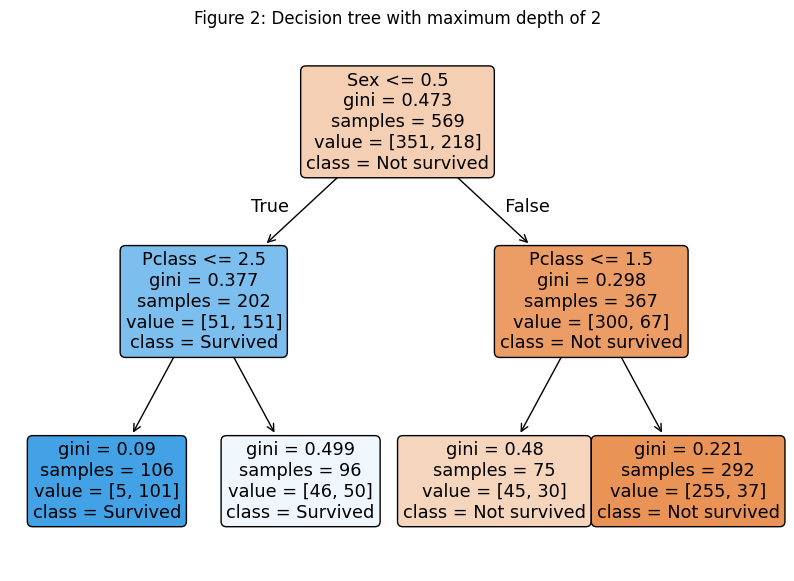

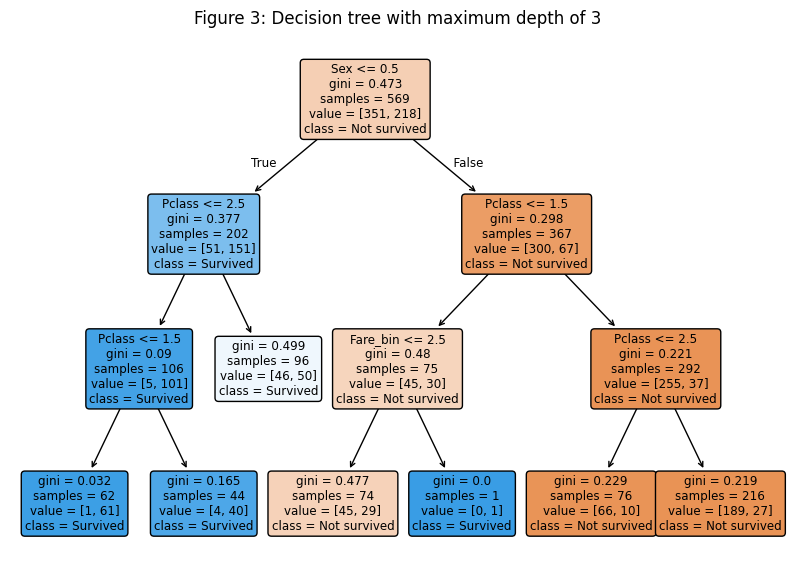

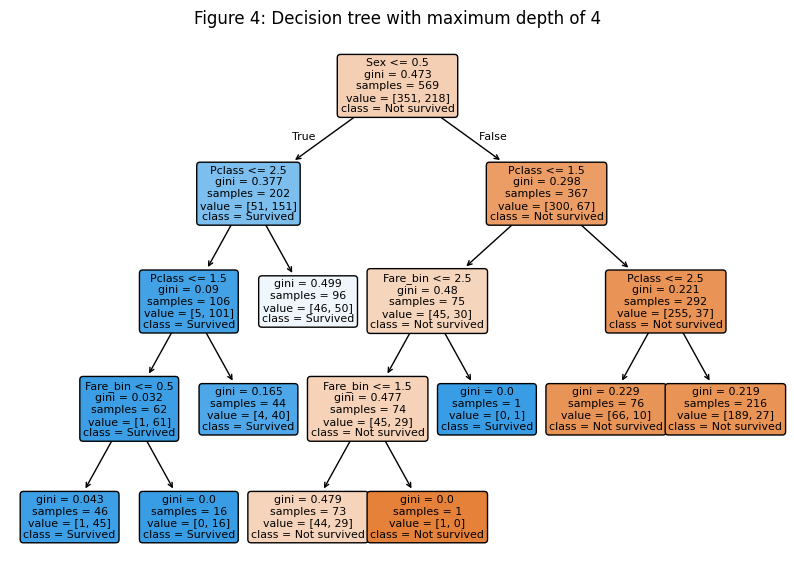

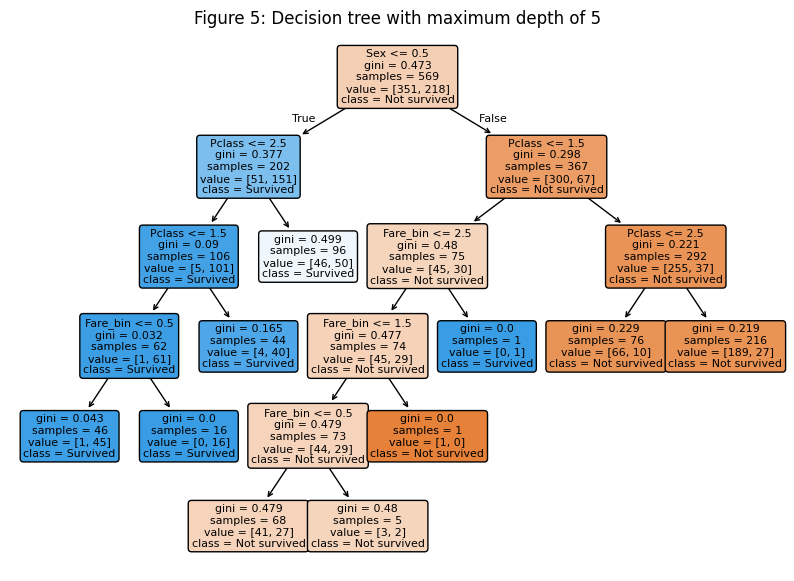

In [24]:
max_depth_values = [2, 3, 4, 5]
train_accuracies = []
dev_accuracies = []
fig_num = [2, 3, 4, 5]

for max_depth in max_depth_values:
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)
    
    # Accuracy tests
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    dev_acc = accuracy_score(y_dev, clf.predict(X_dev))
    train_accuracies.append(train_acc)
    dev_accuracies.append(dev_acc)
    
    # Create trees
    plt.figure(figsize=(10, 7))
    plot_tree(
        clf,
        feature_names=['Pclass', 'Sex', 'Fare_bin'],
        class_names=['Not survived', 'Survived'],
        filled=True, rounded=True
    )
    plt.title(f'Figure {fig_num[max_depth_values.index(max_depth)]}: Decision tree with maximum depth of {max_depth}')
    plt.show()


#### 6.2 Calculate training and development set accuracy scores

The scores below are exactly the same as when the decision tree was not limited to a certain depth, except for a slight improvement of 0.001 when moving from 2 to 3 levels. If increasing the maximum depth does not change the accuracy, the tree is not using the extra depth because the data in this case is fairly simple and does not support a complex tree. The lower number of splits already accomodate the data that the model is given and further data would be needed to grow the tree.

The training and development scores being close together also suggests the model is not overfitting (memorising) or underfitting (failing to learn) and thus generalises reasonably well.

In [25]:
print(
    'Accuracy scores for training set (2 to 5 max depth):',
    [f'{score:.3f}' for score in train_accuracies]
)

print(
    'Accuracy scores for development set (2 to 5 max depth):',
    [f'{score:.3f}' for score in dev_accuracies]
)

Accuracy scores for training set (2 to 5 max depth): ['0.793', '0.794', '0.794', '0.794']
Accuracy scores for development set (2 to 5 max depth): ['0.776', '0.776', '0.776', '0.776']


#### 6.3 Plot and compare training and development accuracy scores

A line graph is now plotted in Figure 6 comparing the training accuracies with development accuracies on the same graph. The x-axis shows the max_depth values from 2 to 5 and the y-axis shows the accuracy scores for the training data in blue and the development data in orange. As can be expected, the model performs better on its original training data, but the difference between the training and development set accuracy is not large at any point (between 0.016 and 0.017). 

When checking the accuracy scores for models with 6 to 10 levels, the scores remain the same, as shown in the appendix. This small gap between the two lines suggests a well-generalised model. The main results from this section to note are the accuracy score of 0.776 for new data and the maximum tree depth of 5 levels. 

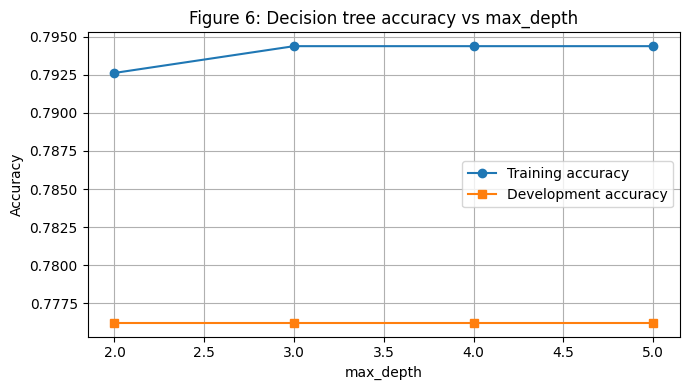

In [20]:
plt.figure(figsize=(7, 4))
plt.plot(max_depth_values, train_accuracies, marker='o', label='Training accuracy')
plt.plot(max_depth_values, dev_accuracies, marker='s', label='Development accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Figure 6: Decision tree accuracy vs max_depth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 7. Select and train final model

I will now set the maximum depth at 5, train the final model using the training set, and check its accuracy on the test set. The final model has a score of 0.782 and has performed almost equally well as with the training set (0.794) and better than the development set (0.776). This might be because there are more samples in the test set (179) compared to the development set (143), giving the model more opportunity to predict correctly.

In [21]:
final_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
final_clf.fit(X_train, y_train)

y_test_pred = final_clf.predict(X_test)  # Predict on the test set

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Classifier accuracy score for test set: {test_accuracy:.3f}')

Classifier accuracy score for test set: 0.782


#### References

Cukierski, W. (2012). Titanic - Machine Learning from Disaster. Kaggle. https://kaggle.com/c/titanic/data 

Geeks for Geeks. (2025). How Decision Tree Depth Impact on the Accuracy. https://www.geeksforgeeks.org/machine-learning/how-decision-tree-depth-impact-on-the-accuracy

Geeks for Geeks. (2024). How to use pandas cut() and qcut()? https://www.geeksforgeeks.org/python/how-to-use-pandas-cut-and-qcut

Hunt, G. (2016). Titanic Dataset Investigation. https://ghunt03.github.io/DAProjects/DAP02/TitanicDatasetInvestigation.html

HyperionDev. (2025). Supervised Learning – Decision Trees. Course materials. Private repository, GitHub.

IBM. (n.d.). What is a decision tree? https://www.ibm.com/think/topics/decision-trees

Lescano, A. (n.d.). Titanic Survival Prediction with Decision Tree. Deep Note. https://deepnote.com/app/alivasples/Titanic-Survival-Prediction-Decision-Tree-85456baf-8725-4718-b954-0876c3c6ba57

Płoński, P. (2020). Visualize a Decision Tree in 5 Ways with Scikit-Learn and Python.https://mljar.com/blog/visualize-decision-tree

Saini, A. (2025). Decision Tree Algorithm. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2021/08/decision-tree-algorithm

scikit-learn. (2024). DecisionTreeClassifier. https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

scikit-learn. (2024). plot_tree. https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html

scikit-learn. (2024). Post pruning decision trees with cost complexity pruning. https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

scikit-learn. (2024). 1.10. Decision Trees. https://scikit-learn.org/stable/modules/tree.html

scikit-learn. (2024). train_test_split. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Steiger, T. (2017). Analysis of Titanic Survival Data. https://ttsteiger.github.io/projects/titanic_report.html

### Appendix

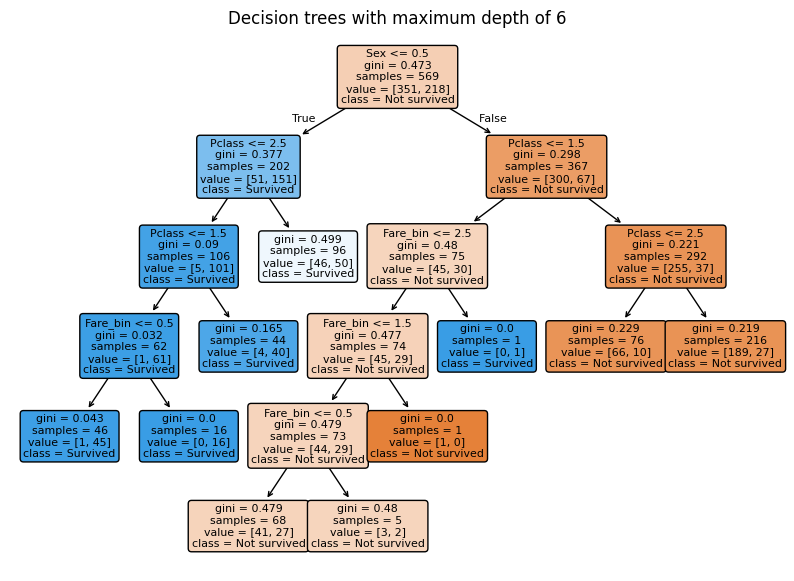

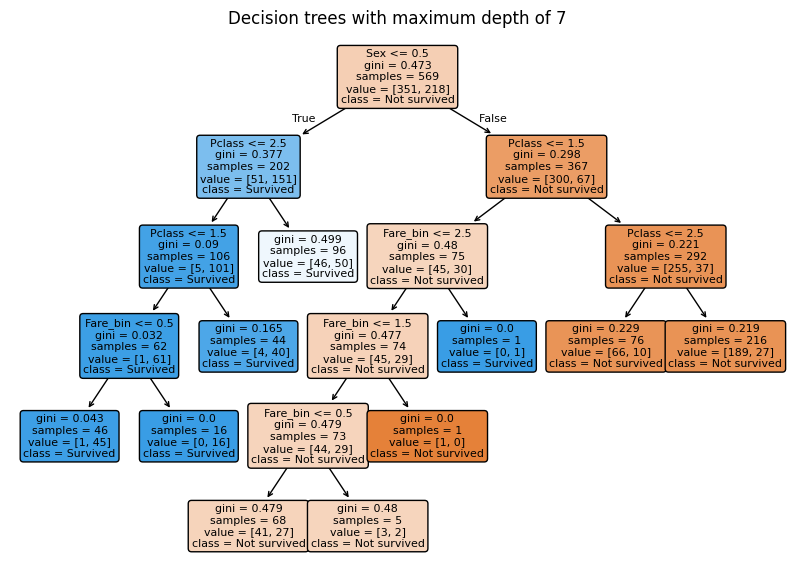

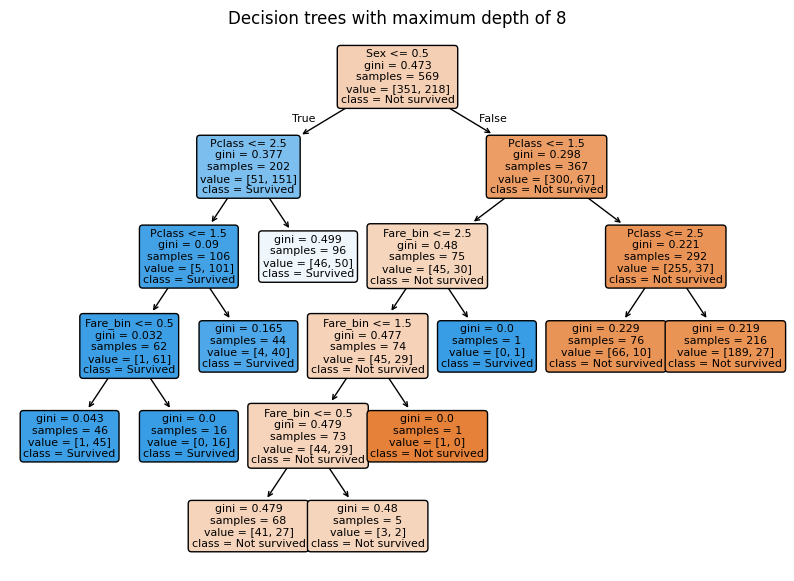

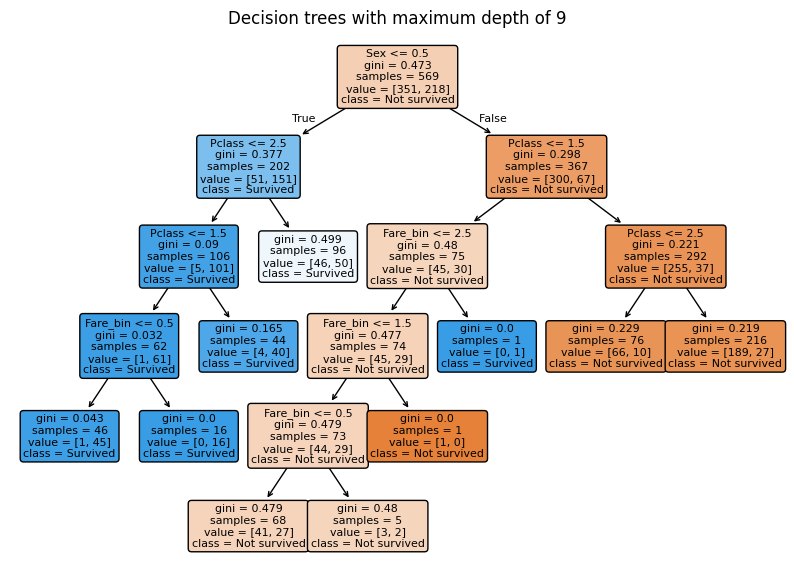

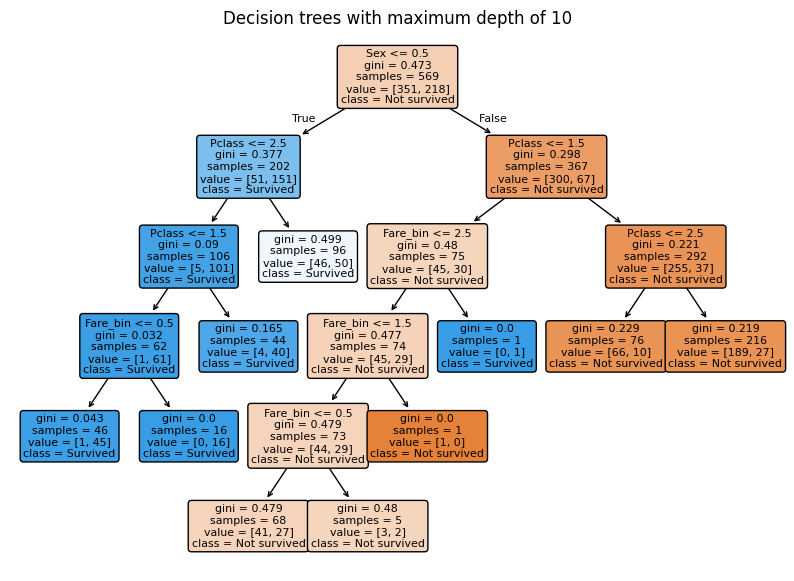

Accuracy scores for training set (2 to 5 max depth): ['0.794', '0.794', '0.794', '0.794', '0.794']
Accuracy scores for development set (2 to 5 max depth): ['0.776', '0.776', '0.776', '0.776', '0.776']


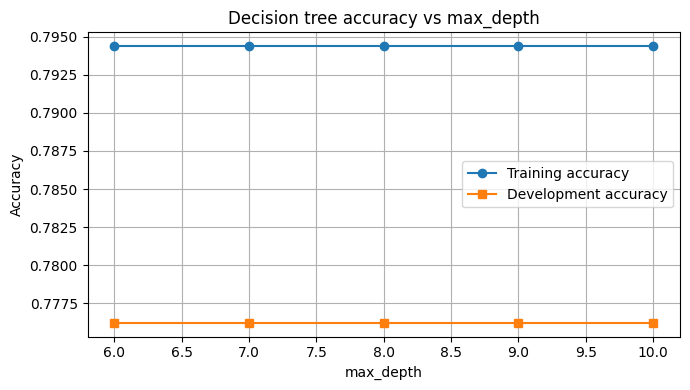

In [26]:
# Plot figures for 6 to 10 max_depth

max_depth_values_6_10 = [6, 7, 8, 9, 10]
train_accuracies = []
dev_accuracies = []

for max_depth in max_depth_values_6_10:
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)
    
    # Accuracy tests

    train_acc = accuracy_score(y_train, clf.predict(X_train))
    dev_acc = accuracy_score(y_dev, clf.predict(X_dev))
    train_accuracies.append(train_acc)
    dev_accuracies.append(dev_acc)
    
    # Visualise trees

    plt.figure(figsize=(10, 7))
    plot_tree(
        clf,
        feature_names=['Pclass', 'Sex', 'Fare_bin'],
        class_names=['Not survived', 'Survived'],
        filled=True, rounded=True
    )
    plt.title(f'Decision trees with maximum depth of {max_depth}')
    plt.show()


# Print accuracy scores

print(
    'Accuracy scores for training set (2 to 5 max depth):',
    [f'{score:.3f}' for score in train_accuracies]
)

print(
    'Accuracy scores for development set (2 to 5 max depth):',
    [f'{score:.3f}' for score in dev_accuracies]
)

# Display accuracy scores on graph

plt.figure(figsize=(7, 4))
plt.plot(max_depth_values_6_10, train_accuracies, marker='o', label='Training accuracy')
plt.plot(max_depth_values_6_10, dev_accuracies, marker='s', label='Development accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Decision tree accuracy vs max_depth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()